# NFL Big Data Bowl 2021- Defensive Performance on Passing Plays

**Preparing The Data Infrastructure**

To effectively analyze each defender’s effectiveness in defending against the pass, we must know (a) the intended receiver of a pass play and (b) the closest defender to that receiver. To do so, we leverage the x-y coordinates in the weekly player-tracking data, as well as the play description field in the “plays.csv” dataset. First, for each gameId, playId, and frameId combination in the playter-tracking data, we find the distance between each offensive and defensive player on the field, then filter to find the closest defensive player to each offensive player at a point in time during the play. Next, by parsing the play description, we determine the targeted receiver of a pass play, whether the result was a completion, incompletion, or interception.

Using our first step, we then find the closest defender to the targeted receiver at points of time of interest; for purposes of our analysis, these are the time the ball is released (event = “pass_forward”) and the time the outcome of the play is determined (event = “pass_ouctome_caught” OR “pass_outcome_incomplete” OR “pass_outcome_interception” OR “pass_outcome_touchdown”). Both points in time are relevant to our analysis; the distance between the targeted receiver and the closest defender at the time the ball is released reflects the defender’s ability to prevent the receiver from getting open enough to warrant a target, while the distance at the time the play’s outcome is determined reflects the defender’s ability to close on a receiver and defend against the pass when the ball arrives. (Note: The closest defender to a targeted receiver at the time the ball is released will not always be the closest defender to a targeted receiver at the time the play’s outcome is determined; e.g., a receiver running a crossing route in a zone defense might get passed off from one defender to another, or a ball thrown up for grabs might create a crowd of defenders around the receiver, as in a Hail Mary.)

Separately, we perform a related analysis using the x-y coordinates of the football itself. We determine the straight-line distance traveled by the football from the time the ball is released to the time the play’s outcome is determined. In addition, we also calculate the time in seconds that elapsed between these two events. Both variables are intended to account for the difficulty of the pass (e.g., a 5-yard pass is likely easier to complete than a 50-yard pass, all else equal) as well as the amount of time a defender has to adjust to the ball once it is in the air.  

**Summary Statistics - Rankings by Position Group**

As an initial step, we rank players by position group based on four statistics that measure their effectiveness against the pass:

1. **Target Share:** Defined as the number of plays on which a defender was targeted, divided by the number of passing plays for which the defender was on the field. A defender is deemed to be “targeted” if he is the closest defender to the targeted receiver at the time the ball is released.
2. **Completion Rate:** Defined as the number of completed passes allowed by a defender, divided by the number of plays on which a defender was targeted.
3. **Yards per Target:** Defined as the number of yards allowed by a defender, divided by the number of plays on which a defender was targeted.
4. **Yards per Completion:** Defined as the number of yards allowed by a defender, divided by the number of plays on which the defender was targeted and allowed a completed pass.

Our hypothesis was that the best defenders should have lower target shares (because quarterbacks will be less inclined to throw in their direction); lower completion rates, lower yards per target, and lower yards per completion. Defenders who were not targets on at least 10 plays are not considered for this analysis.

Given that certain pass plays are more likely to be defended by certain defenders (i.e., safeties are more likely than linebackers to be targeted on large, chunk yardage plays), we rank players within their position groups to allow for more realistic comparisons between players. Given the detail of the player position data provided, we perform aggregation to group similar positions together, as shown in **Figure A** below:

**Figure A - Position Groupings**
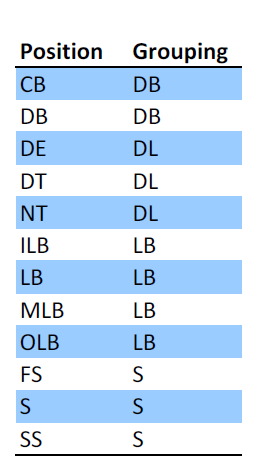

After ranking each player on each metric within their position group, we calculate the average rank across the four metrics to arrive at an overall ranking. Results for each position group are shown below, with the exception of defensive linemen, for which only four players met the target minimum threshold for inclusion. The results show that this simple analysis is successful in identifying decorated players, especially among safeties. This makes sense, as accolades for safeties are predominantly determined by their performance against the pass, compared to linebackers, who are more prominent in the run game.

**Figure B - Safeties**
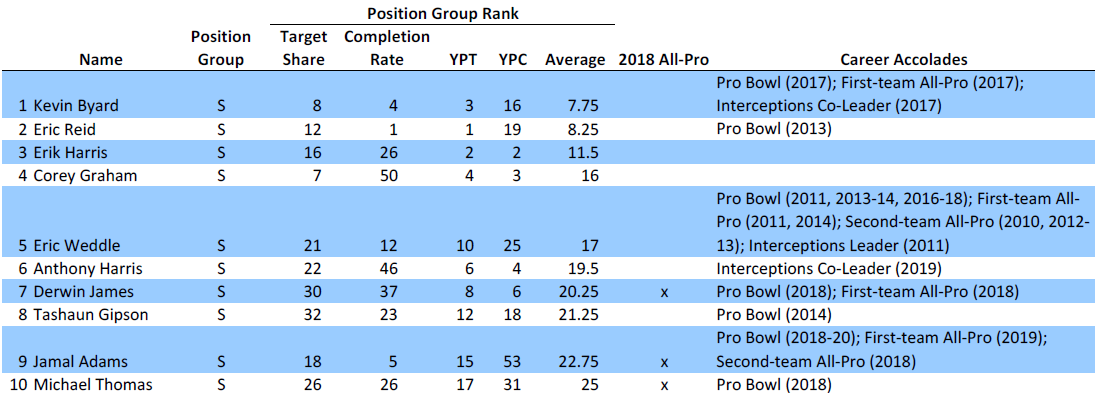

**Figure C - Defensive Backs**
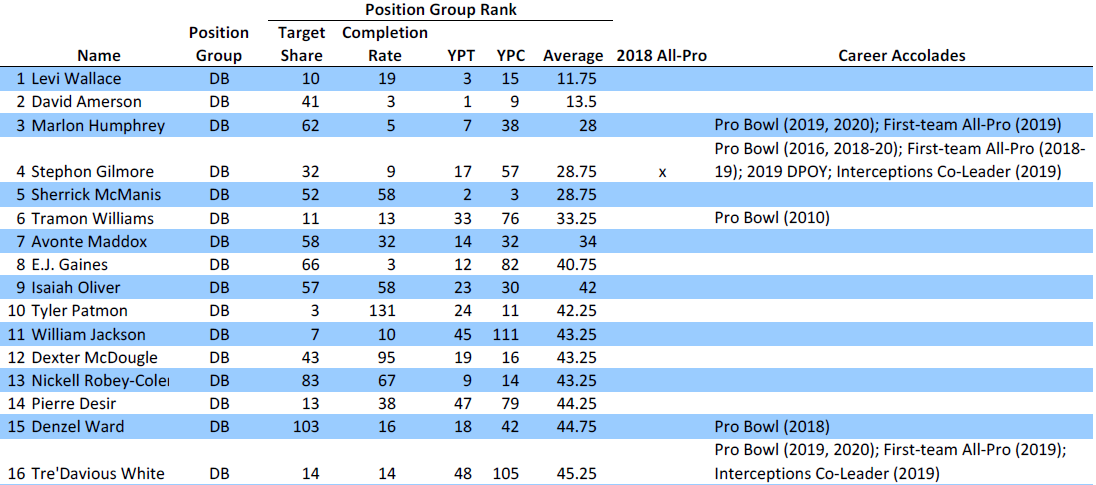

**Figure D - Linebackers**
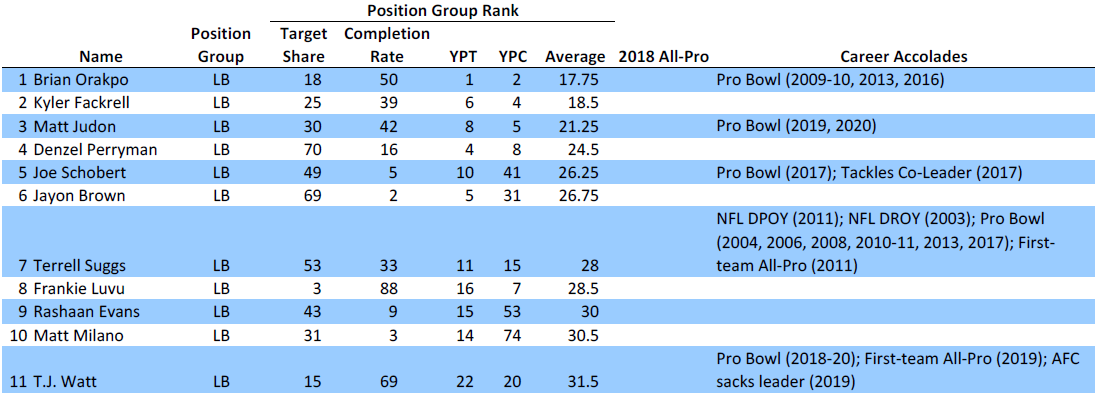

**Predicting the Likelihood of A Completed Pass**

Next, we examine the impact of defenders on the likelihood that a pass will be completed, controlling for several important factors outlined below. We first identify the universe of plays to examine: pass plays for which a targeted defender and the route run by the targeted receiver can be identified, during which the offense did not commit a penalty, and for which data exist to determine both the distance traveled by the football and the length of time the ball was in the air. The sample is further limited to defenders who were targeted on at least 20 plays.

Given this sample, we run a logistic regression, where the dependent variable is a binary variable that takes a value of 0 for incompletions or interceptions and takes a value of 1 for completions. The independent variables included as part of the model are:
* The Euclidean distance in yards between the targeted receiver and targeted defender at the time the play’s outcome is determined (the frame at which the ball is caught/dropped/intercepted).
* The time in seconds between when the ball is snapped and when the quarterback releases the ball.
* The Euclidean distance in yards traveled by the football.
* The time in seconds that the football is in the air.
* The route run by the targeted receiver
* The down
* The targeted defender

**Figure E** below shows the result of our model for all variables except the defensive player. Because it is a logistic regression, the results shown in **Figure E** cannot be interpreted as the change in response to a one-unit change in an independent variable. Rather, they reflect the change in the log-odds ratio of a completed pass. For example, giving the quarterback an additional second to pass results in a 0.206 decrease in the log-odds ratio of a completed pass, or an e^-0.206 = factor of 0.813 effect (18.7% decrease) on the odds-ratio of a completion.

**Figure E**
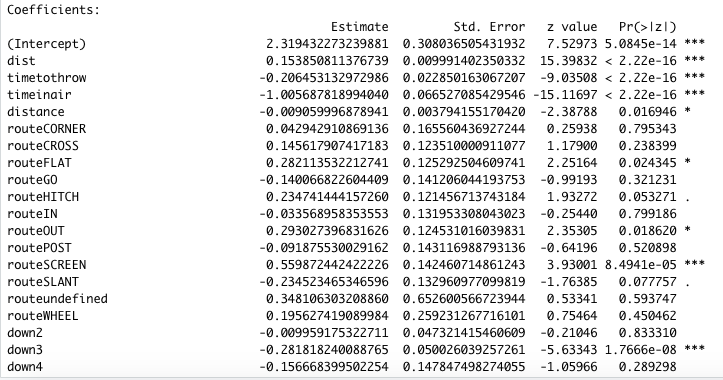

**Figure F** below reports the defenders who, when targeted, had the largest decrease in the odds ratio of a completed pass, relative to the baseline. We observe many names at the top of this list who also appeared in our simple summary statistics exhibits, which is a positive result for our model.

**Figure F**
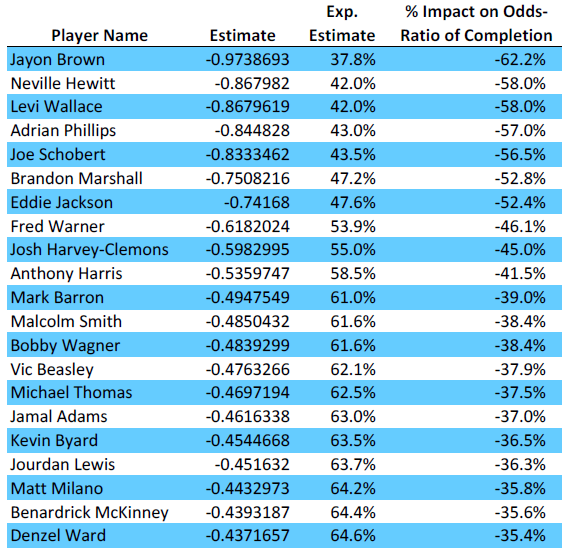

By applying a cut-off value of 0.6, we classify each pass play using our model as a completion or not a completion. From there, we can examine the specificity and sensitivity of our model, shown below in **Figure G**. We find the model is able to successfully predict a completed pass 80% of the time, while correctly identifying an incomplete or intercepted pass around 60% of the time.

**Figure G**
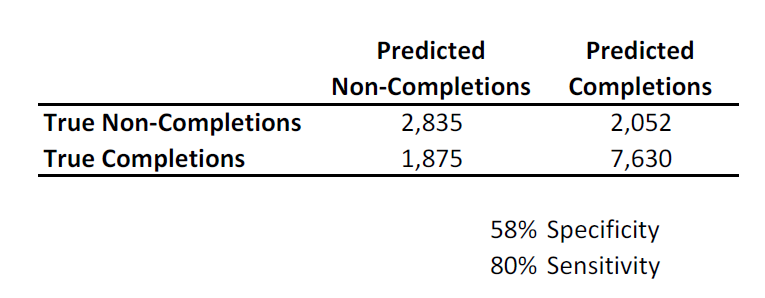

Of course, not all completed passes are created equal - some go for just a few yards, others go for big plays. Some convert a first down or a touchdown, while others are short of first down yardage. The models described in the next section address this heterogeneity.

**Ranking defensive players by their ability to defend the pass when the ball arrives**

In this section, we attempt to rank defensive players by their ability to defend the pass when the ball arrives while addressing the heterogeneity across pass plass mentioned in the previous section.  To do so, we constructed an ordinary least squares regression model. 

Our left-hand side variable is expected points added (EPA).  We feel that this is an appropriate outcome variable because it quantifies the relative value of various play outcomes (pass incomplete, pass complete, interception, etc.) while making a distinction between the relative value of a first-down incompletion at the 50-yard line from a fourth-down incompletion on the goal-line.

In order to determine the relevant defensive player for each play, we identified the intended receiver and, subsequently, the defender nearest to the intended receiver player (e.g. the minimum Euclidean distance) in the frame when the pass arrives (for our methodology of these identifications, see discussion from the previous section).  The nearest defensive player (the “targeted defender”) is assumed to be the defender who is defending the pass when the ball arrives for the given play.  

As can be seen in **Figure H**, the median distance of the targeted defender from the intended receiver when the ball arrives is approximately 3 yards.  While this indicates that for many of the plays, we are focusing on a defender who is quite close to the intended receiver, we also note that we will need to account for the dispersion in this metric such that our model does not mistake poor performance when the ball arrives with a defender being too far away from the intended receiver to have any impact.

**Figure H**
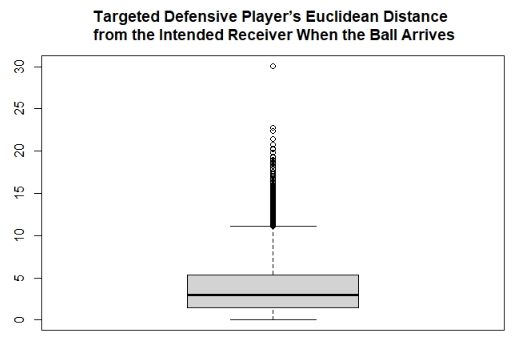
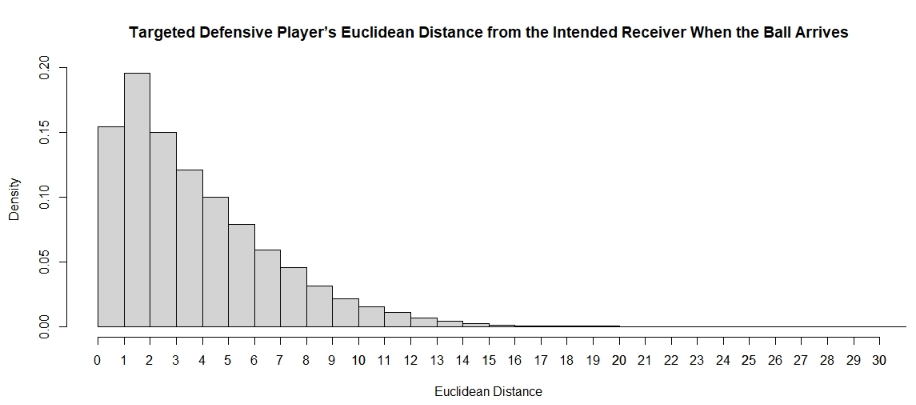

To measure defensive player performance when the ball arrives, our model contains a series of dummy variables for each defensive player in the data, where only the targeted defender’s dummy is set equal to 1 on a given play and all other defensive player dummy variables are set equal to 0.  Conceptually, if a defender is especially adept at defending when the ball arrives, that player should have a negative impact on EPA and thus that defender’s dummy variable should have a coefficient that is negative.  Conversely, if a defender is inept at defending when the ball arrives, that defender’s dummy should have a coefficient that is positive.  

In order for our targeted defender dummy variables to be meaningful, our model must include a number of controls:

1. **Quarterback dummy:** A dummy variable for each quarterback to control for a quarterback’s skill level.  The dummy variable for the quarterback throwing the pass on a given play is equal to 1; for all other quarterbacks, their respective dummy variables are set equal to 0.  

2. **Intended Receiver dummy:** A dummy variable for each receiver to control for a receiver’s skill level.  The dummy variable for the intended receiver on a given play is equal to 1; for all other receivers, their respective dummy variables are set equal to 0.  

3. **Down dummy:** A series of dummies for the down on a given play to control for unique player behavior attributable to the given down.  On first down, for example, the first down dummy is set equal to 1 whereas all other down dummies are set equal to 0.

4. **Yards to go:** A continuous variable that captures, on a given play, the number of yards needed for a first down.  This controls for unique player behavior attributable to the number of yards needed for a first down.  

5. **Down & Yards to go interaction:** A variable that is the interaction between the above described down dummy variables and yards to go variable, which controls for unique player behavior attributable to the combination of the given down and the yards needed for a first down (that is not already captured by the individual down dummy variables and yards to go variable).

6. **Pass Distance:** Calculated as the Euclidean distance traveled by the ball from the time that the ball is thrown (in the tracking data: play_event = “pass_forward”) until the pass is either caught, ruled incomplete, intercepted, or caught for a touchdown (in the tracking data: play_event = “pass_outcome_caught” or “pass_outcome_incomplete or “pass_outcome_intercepted” or “pass_outcome_touchdown).  This controls for player behavior attributable to the distance that the football travels in the air before arriving at the intended receiver.  

7. **Pass Time:** Calculated as the time elapsed from the time that the ball is thrown until the pass is either caught, ruled incomplete, intercepted, or caught for a touchdown.  This variable controls for the amount of time the intended receiver and targeted defender have to react to the ball being thrown in their direction.

8. **Targeted Defender’s Distance from the Intended Receiver (“nearestOpp.dist” in Figure J):** Calculated as the Euclidean distance of the targeted defender from the intended receiver at the time that the pass arrives.  This variable controls for instances where, when the ball arrives, the defender is too far away from the intended receiver to have a meaningful impact on the receiver’s ability to catch the ball.

**Notable data filters:**
* We drop plays where the quarterback spikes the ball
* We drop plays that resulted in a fumble
* We drop plays the offense committed a penalty
* We drop plays for which we were unable to calculate Pass Time or Pass Distance due to missing data

After running the regression model, we generate a ranking of the defensive players who are the most effective at defending when the ball arrives, where the defensive player whose dummy variable is the most negative is ranked the highest (i.e. best) and the defensive player whose dummy variable is the most positive is ranked lowest (i.e. worst).  

In our final ranking, we impose a minimum number of plays in which a defensive player was targeted in order to ensure that our ranking only includes players who demonstrated consistent success at defending when the ball arrives.  In **Figure I**, we show that 20 plays is the median number of times in which a defensive player was targeted in our dataset, and thus impose a 20 play minimum.

**Figure I**
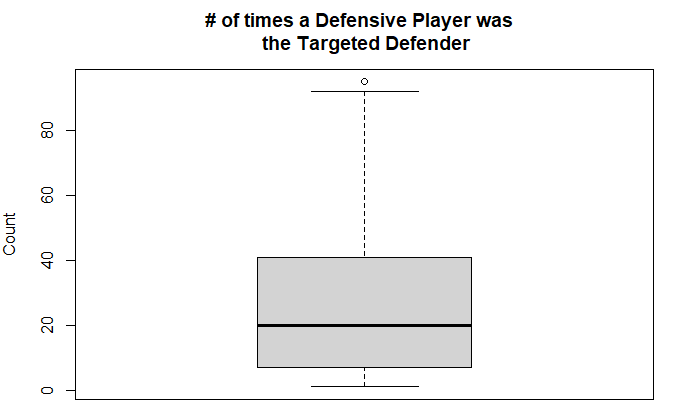

In **Figure J**, we report our regression model results exclusive of the Quarterback, Intended Receiver, and Targeted Defender dummy variables:



**Figure J**
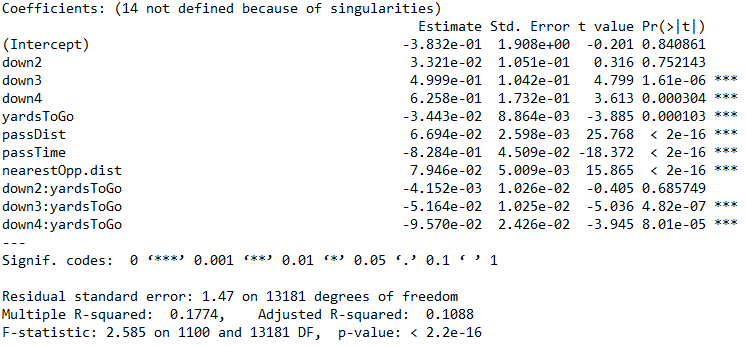

In **Figure K** below, we display the top 20 players per our model. 

We note that several of the players in our top 20 received All-Pro or Pro Bowl accolades in 2018, suggesting that our ranking does have a relationship with more subjective defensive player rankings.  Furthermore, we note that many of the players in our top 20 received All-Pro or Pro Bowl accolades at one point in their NFL careers, suggesting that our ranking is also identifying players who are historically strong performers.

[**Figure K**](https://ibb.co/4Ff81NT)

In **Figure L**, we display the top 10 players by major positional category.  We again note that the position rankings contain both several plays who received All-Pro or Pro Bowl accolades in 2018 and All-Pro or Pro Bowl accolades at one point in their NFL careers.

[**Figure L**](https://ibb.co/cL5h8L0)

As a robustness check, we also ran the same model while restricting the data to only plays in which, at the time the ball arrives, the targeted defender is within 5.3 yards of the intended receiver (5.3 yards corresponds to the 3rd quartile of this metric, as seen in **Figure H**).  This sensitivity serves an additional safeguard against our model attributing poor defensive player performance when the ball arrives to situations when the defender is too far away from the intended receiver to have any impact (in other words, a robustness check that the Targeted Defender’s Distance from the Intended Receiver variable is a sufficient control for this potential issue).  

In **Figure M** below, we display the top 20 players per the restricted version of our model. 

[**Figure M**](https://ibb.co/xFDmhxF)


In **Figure N**, we compare the top 20 players per unrestricted and restricted versions of our model, demonstrating that our ranking is fairly consistent irrespective of the restriction.

[**Figure N**](https://ibb.co/jkJc6mv)


**Other Considerations**

We recognize that there are other factors at play that determine the likelihood of a pass completion or incompletion. To attempt to achieve a higher specificity and sensitivity we utilized our football knowledge to parse out insignificant outliers. 

First, we removed all plays with two minutes remaining in the game, because there are other factors at play besides a one-on-one between a defender and receiver. For example, a team may be up 10 points with 1 minute remaining and content with allowing a 10 yard gain underneath the coverage in the middle of the field. One could argue that these final two minutes possess the highest magnitude of leverage, but for that reason we should analyze the data differently than the bulk of the data. After analyzing our model’s prediction ability of completion vs. non completion we unfortunately found that parsing the end of game data made an insignificant difference.

Next, we removed plays that occurred when a team is winning or losing by greater than 3 scores (24 points). A 3 score deficit is unlikely to overcome and becomes an exercise in running out the clock to end the game. Our logic is that the leading team has no reason to “clamp down” on defense when up by 3 scores and, in the same sense, the losing team will play a more aggressive style of defense when it has nothing to lose and needs to sell out in an attempt to make a comeback. We hypothesized that removing data to account for a change in mentality when there is a large point difference would result in a better model fit, but we unfortunately found that removing this data did not make the model more effective or predictive. 

Finding how to manipulate the player tracking data to create the best model proved to be difficult. We recognize this and have identified plans for future research to further the development of predicting pass defense success.

**Future Research**

In the future we would like to analyze a defense as a unit. One player can make a difference, but successful defenses (1985 Bears, 1991 Eagles, 2000 Ravens) are the product of their ability to act as a unit.  It is not one defender's ability to cover one on one when the ball is in the air, but the ability for the defensive line to pressure the quarterback, a linebacker to cover a larger zoned area, and a safety’s ability to recognize a pass play vice a run play. 

Future hypotheses we would like to analyze would be the make up and construction of successful teams. Do more successful teams spend more money or draft capital on defensive ends vice strong safeties? What percentage of salary to successful teams allocate to the secondary vice the pass rush? Everything works together in harmony to lead to success and, although there are a vast number of data points, the sample size is relatively small with units playing at most 16 regular season games.


In [ ]:
###APPENDIX A: Code for Summary Statistic and Logistic Regression Analyses
#Read in the Data
players <- read.csv("players.csv")
games <- read.csv("games.csv")
plays <- read.csv("plays.csv")
week1 <- read.csv("week1.csv")
all_weeks <- week1

for (w in c(2:17)) {
  new_week <- read.csv(paste("week",w,".csv",sep=""))
  #new_week <- subset(new_week,event !="None")
  all_weeks <- rbind(all_weeks,new_week)
}
save(all_weeks,file="All_Weeks_All_Frames.RData")
all_weeks_allframes <- all_weeks
rm(new_week)
rm(week1)
all_weeks <- subset(all_weeks,event !="None")

###Joining the datasets to create the master dataset for distance analysis
test2 <- left_join(all_weeks,games,by="gameId"); head(test2)
test4 <- left_join(test2,plays,by=c("gameId","playId"))
rm(test2)
save(test4,file="Plays_Tracking_All_Weeks.RData")

##CREATING THE MASTER DATASET###
master <- test4; rm(test4)
#Add flags to figure out whether a player is on defense or offense
master$opp_team <- ifelse(master$team=="away","home","away")
#Calculate distance from opposing player at every frame
master_distance <- left_join(master[,c("gameId","playId","frameId","team","displayName","x","y")],master[,c("gameId","playId","frameId","opp_team","displayName","x","y")],by=c("gameId"="gameId","playId"="playId","frameId"="frameId","team" ="opp_team"))
master_distance <- subset(master_distance,displayName.y != "Football")
master_distance$dist <- ((master_distance$x.x - master_distance$x.y)^2 + (master_distance$y.x - master_distance$y.y)^2)^0.5
summary(master_distance$dist)
#Get closest opposing player at every frame
master_distance2 <- master_distance %>% group_by(displayName.x,gameId,playId,frameId) %>% slice(which.min(dist))
rm(master_distance)
#Join closest defender information to larger dataset
master <- left_join(master,master_distance2[,c("gameId","playId","frameId","displayName.x","displayName.y","x.y","y.y","dist")],by=c("gameId","playId","frameId","displayName" = "displayName.x"))
rm(master_distance2)

#Find the target for every play
master$target <- NA
master$target_flag <- NA

for(i in 1:nrow(master)) {
  ifelse(master$passResult[i] == "IN", tmp <- strsplit(master$playDescription[i],"pass.*for [A-Z]\\.")[[1]][2],tmp <- strsplit(master$playDescription[i],"pass.*to [A-Z]\\.")[[1]][2])
  tmp <- strsplit(tmp, " ")[[1]][1]
  tmp <- gsub("\\.","",tmp)
  ifelse(is.na(tmp),master$target[i] <- "MISSING",master$target[i] <- tmp)
  name <- master$displayName[i]
  master$target_flag[i] <- grepl(tmp,name)
}

master$possession <- ifelse(master$possessionTeam==master$homeTeamAbbr,"home","away")
master$OD_flag <- ifelse(master$team=="football","football",ifelse(master$possession==master$team,"offense","defense"))
save(master,file="Master_with_Distance_Target.RData")

master_offense <- subset(master,OD_flag=="offense") #Filter to just offensive players (no defense or football)
master_offense <- subset(master_offense, playResult >-10 & (penaltyCodes=="" | (penaltyCodes !="" & playResult >=0))) #Filter to plays without penalties or penalties moving the ball backward and excludes very negative plays (mostly fumble recovery TDs)
master_offense_passforward <- subset(master_offense,event=="pass_forward") #Only the frame when the ball is passed forward
master_offense_passforward$defender_team <- ifelse(master_offense_passforward$possessionTeam==master_offense_passforward$homeTeamAbbr,master_offense_passforward$visitorTeamAbbr,master_offense_passforward$homeTeamAbbr)
master_targets_passforward <- subset(master_offense_passforward,target_flag==TRUE) #Only the targeted receiver on a given play


###FINDING MOVEMENT OF THE FOOTBALL AND TIME IN AIR###
football <- subset(master[,c("gameId","playId","displayName","passResult","playDescription","time","event","x","y")],displayName=="Football" & (event=="pass_forward" | event=="pass_outcome_caught" | event=="pass_outcome_incomplete" | event=="pass_outcome_interception" | event=="pass_outcome_touchdown"))
football_forward <- subset(football,event=="pass_forward")
football_complete <- subset(football,event=="pass_outcome_caught")
football_incomplete <- subset(football,event=="pass_outcome_incomplete")
football_touchdown <- subset(football,event=="pass_outcome_touchdown")
football_interception <- subset(football,event=="pass_outcome_interception")

football_merged <- left_join(football_forward[,c("gameId","playId","displayName","passResult","playDescription","x","y","time")],football_complete[,c("gameId","playId","x","y","time")],by=c("gameId","playId"),suffix=c("_forward","_complete")) %>%
                left_join(.,football_incomplete[,c("gameId","playId","x","y","time")],by=c("gameId","playId"),suffix=c("","_incomplete")) %>%
                left_join(.,football_touchdown[,c("gameId","playId","x","y","time")],by=c("gameId","playId"),suffix=c("_incomplete","_touchdown")) %>%
                left_join(.,football_interception[,c("gameId","playId","x","y","time")],by=c("gameId","playId"),suffix=c("","_interception"))

football_merged <- football_merged %>% 
  rename(x_interception = x, y_interception = y, time_interception = time)
 
rm(football_complete,football_forward,football_incomplete,football_touchdown,football_interception,football)

football_merged$distance <- NA
football_merged$timeinair <- NA
for(i in 1:nrow(football_merged)) {
  if(football_merged$passResult[i]=="C") {
    football_merged$distance[i] <- ((football_merged$x_complete[i] - football_merged$x_forward[i])^2 + (football_merged$y_complete[i] - football_merged$y_forward[i])^2)^0.5
    football_merged$timeinair[i] <- as.numeric(as.POSIXct(football_merged$time_complete[i],format="%Y-%m-%dT%H:%M:%OS")) - as.numeric(as.POSIXct(football_merged$time_forward[i],format="%Y-%m-%dT%H:%M:%OS"))
  }
  if(football_merged$passResult[i]=="C" & is.na(football_merged$distance[i])) {
    football_merged$distance[i] <- ((football_merged$x_touchdown[i] - football_merged$x_forward[i])^2 + (football_merged$y_touchdown[i] - football_merged$y_forward[i])^2)^0.5
    football_merged$timeinair[i] <- as.numeric(as.POSIXct(football_merged$time_touchdown[i],format="%Y-%m-%dT%H:%M:%OS")) - as.numeric(as.POSIXct(football_merged$time_forward[i],format="%Y-%m-%dT%H:%M:%OS"))
  }  
  if(football_merged$passResult[i]=="I") {
    football_merged$distance[i] <- ((football_merged$x_incomplete[i] - football_merged$x_forward[i])^2 + (football_merged$y_incomplete[i] - football_merged$y_forward[i])^2)^0.5
    football_merged$timeinair[i] <- as.numeric(as.POSIXct(football_merged$time_incomplete[i],format="%Y-%m-%dT%H:%M:%OS")) - as.numeric(as.POSIXct(football_merged$time_forward[i],format="%Y-%m-%dT%H:%M:%OS"))
  }
  if(football_merged$passResult[i]=="IN") {
    football_merged$distance[i] <- ((football_merged$x_interception[i] - football_merged$x_forward[i])^2 + (football_merged$y_interception[i] - football_merged$y_forward[i])^2)^0.5
    football_merged$timeinair[i] <- as.numeric(as.POSIXct(football_merged$time_interception[i],format="%Y-%m-%dT%H:%M:%OS")) - as.numeric(as.POSIXct(football_merged$time_forward[i],format="%Y-%m-%dT%H:%M:%OS"))
  }  
}

plays2 <- left_join(plays,football_merged[,c("gameId","playId","distance","timeinair")],by=c("gameId","playId"))
plays3 <- left_join(plays2,master_targets_passforward[,c("gameId","playId","event","displayName","target_flag","displayName.y","dist")],by=c("gameId","playId"))
plays4 <- plays3 %>% group_by(gameId,playId) %>% slice(1)
save(plays4,file="Augmented_Plays_Dataset.RData")

#Calculate number of snaps by defensive player
snaps_by_player <- subset(master_offense_passforward,!is.na(displayName.y))
snaps_by_player <- snaps_by_player %>% group_by(gameId,playId,frameId,displayName.y) %>% slice(1)
snaps_by_player <- snaps_by_player %>% group_by(displayName.y) %>% count(displayName.y,sort=TRUE)

#Calculate number of targets by defensive player
targets_by_player <- subset(master_targets_passforward, !is.na(displayName.y))
targets_by_player <- targets_by_player %>% group_by(gameId,playId,frameId,displayName) %>% slice(1)
targets_by_player <- targets_by_player %>% group_by(displayName.y) %>% count(displayName.y,sort=TRUE)

#Calculate the outcome of passes by defensive player (completions and yards)
outcomes_by_player <- subset(master_targets_passforward, !is.na(displayName.y))
outcomes_by_player <- outcomes_by_player %>% group_by(gameId,playId,frameId,displayName) %>% slice(1)
outcomes_by_player2 <- outcomes_by_player %>% group_by(displayName.y,passResult) %>% count(displayName.y,sort=TRUE)
outcomes_by_player3 <- outcomes_by_player %>% group_by(displayName.y) %>% summarise(Yards_Allowed=sum(playResult)) %>% arrange(desc(Yards_Allowed),displayName.y)
outcomes_by_player4 <- spread(outcomes_by_player2,passResult,n)

#Merge the snaps dataframe with the targets dataframe and outcomes tables; calculate summary % stats
target_share <- left_join(snaps_by_player,targets_by_player,by="displayName.y",suffix=c("_snaps","_targets"))
target_share <- left_join(target_share,outcomes_by_player4,by="displayName.y")
target_share <- left_join(target_share,outcomes_by_player3,by="displayName.y")
target_share <- left_join(target_share,players[,c("displayName","position")],by = c("displayName.y"="displayName"))
target_share <- subset(target_share,position != "WR" & position != "RB" & position != "TE")

for(i in 1:nrow(target_share)) {
  if(is.na(target_share$n_targets[i])) { target_share$n_targets[i]=0 }
  if(is.na(target_share$IN[i])) { target_share$IN[i]=0 } 
  if(is.na(target_share$I[i])) { target_share$I[i]=0 }  
  if(is.na(target_share$C[i])) { target_share$C[i]=0 }
  if(is.na(target_share$Yards_Allowed[i])) { target_share$Yards_Allowed[i]=0 }  
}

target_share$target_share <- target_share$n_targets / target_share$n_snaps
target_share$pct_C <- target_share$C/target_share$n_targets
target_share$pct_I <- target_share$I/target_share$n_targets
target_share$pct_IN <- target_share$IN/target_share$n_targets
target_share$YPT <- target_share$Yards_Allowed/target_share$n_targets
target_share$YPC <- target_share$Yards_Allowed/target_share$C

hist(target_share$YPC,breaks=20)

write.csv(target_share,"Target_Share.csv",row.names=FALSE)

football <- subset(all_weeks_allframes,displayName=="Football")
football_snap <- subset(football[,c("gameId","playId","frameId","time","event","displayName","x","y")],event=="ball_snap")
football_forward <- subset(football[,c("gameId","playId","frameId","time","event","displayName","x","y")],event=="pass_forward")
football_maxframe <- football[,c("gameId","playId","frameId","event","time","displayName","x","y")] %>% group_by(gameId,playId) %>% filter(frameId == max(frameId))
plays6 <- subset(plays,passResult=="C" & (penaltyCodes=="" | (penaltyCodes !="" & playResult >=0)))

football_maxframe2 <- inner_join(football_maxframe,plays6[,c("gameId","playId","playDescription","passResult","playResult")],by=c("gameId","playId"))
football_maxframe2 <- left_join(football_maxframe2,football_snap[,c("gameId","playId","x","y")],by=c("gameId","playId"),suffix=c("_max","_snap"))

football_TTT <- left_join(football_forward,football_snap[,c("gameId","playId","time")],by=c("gameId","playId"),suffix=c("_forward","_snap"))
football_TTT$timetothrow <- as.numeric(as.POSIXct(football_TTT$time_forward,format="%Y-%m-%dT%H:%M:%OS")) - as.numeric(as.POSIXct(football_TTT$time_snap,format="%Y-%m-%dT%H:%M:%OS"))

defender_arrival <- subset(master_offense[,c("gameId","playId","event","displayName","route","down","passResult","playResult","playDescription","displayName.y","dist","target_flag")],target_flag==TRUE & route !="" & (event=="pass_outcome_caught" | event=="pass_outcome_incomplete" | event=="pass_outcome_interception" | event=="pass_outcome_touchdown"))
defender_arrival <- left_join(defender_arrival,football_merged[,c("gameId","playId","distance","timeinair")],by=c("gameId","playId"))
defender_arrival <- left_join(defender_arrival,football_TTT[,c("gameId","playId","timetothrow")],by=c("gameId","playId"))
defender_arrival <- defender_arrival %>% group_by(gameId,playId) %>% slice(1)

arrivetargets_by_player <- subset(defender_arrival, !is.na(displayName.y))
arrivetargets_by_player <- arrivetargets_by_player %>% group_by(displayName.y) %>% count(displayName.y,sort=TRUE)
defender_arrival <- left_join(defender_arrival,arrivetargets_by_player[,c("displayName.y","n")],by="displayName.y")
defender_arrival <- subset(defender_arrival,n>=20)
arrivetargets_by_player <- subset(arrivetargets_by_player,n>=20)

defender_arrival$down <- as.factor(defender_arrival$down)
defender_arrival$completion_flag <- ifelse(defender_arrival$passResult=="C",1,0)
defender_arrival <- subset(defender_arrival,is.na(dist)==FALSE  & is.na(timetothrow)==FALSE & is.na(distance)==FALSE & is.na(timeinair)==FALSE & is.na(route)==FALSE & is.na(down)==FALSE & is.na(displayName.y)==FALSE)

#Logistic Regression Model
logit_completion_model <- glm(completion_flag ~ dist + timetothrow + timeinair + distance + route + down + displayName.y, data=defender_arrival, family=binomial); summary(logit_completion_model)
exp(coef(logit_completion_model))

predictions <- as.numeric(logit_completion_model$fitted.values > 0.6); head(predictions)

table(defender_arrival$completion_flag,predictions)

#output results to an external file
options(max.print=5.5E5)
sink(file="logit_completion_model.txt")
summary(logit_completion_model)
sink(NULL)

In [ ]:
###APPENDIX B: Ranking defensive players by their ability to defend the pass when the ball arrives

library(tidyverse)
library(dplyr)
library(stringr)


###   Identify targeted receiver ###
#Create intended receiver variable by parsing playDescription
load(file = "plays.Rdata")
install.packages("stringi")
library(stringi)

plays$intend_1<-substr(str_extract(plays$playDescription, "left to [A-z]{1,}\\.{1}[:space:]?[A-z]+"), 9, stri_length(plays$playDescription))
plays$intend_2<-substr(str_extract(plays$playDescription, "right to [A-z]{1,}\\.{1}[:space:]?[A-z]+"), 10, stri_length(plays$playDescription))
plays$intend_3<-substr(str_extract(plays$playDescription, "middle to [A-z]{1,}\\.{1}[:space:]?[A-z]+"), 11, stri_length(plays$playDescription))
plays$intend_4<-substr(str_extract(plays$playDescription, "intended for [A-z]{1,}\\.{1}[:space:]?[A-z]+"), 14, stri_length(plays$playDescription))
plays$intended<-coalesce(plays$intend_1, plays$intend_2, plays$intend_3, plays$intend_4) 
plays$intended_fInit<-substr(plays$intended, 1, 1)
plays$intended_lName<-trimws(substr(str_extract(plays$intended, "\\.{1}[:space:]?[A-z]+"), 2, stri_length(plays$intended)))


#checks on intended receiver var by parsing playDescription
plays$noval<-is.na(plays$intend_1) & is.na(plays$intend_2) & is.na(plays$intend_3)& is.na(plays$intend_4)
table.noval<-table(plays$noval, plays$passResult)
table.noval
#able to identify the intended receiver for 17.4k out of 19.2k plays (~90%)
#of those unable to identify, the description doesn't contain the information necessary to determine intended receiver
#passresults of those cases are mostly incomplete passes and sacks

#drop intermediate vars
plays$intend_1<-NULL
plays$intend_2<-NULL
plays$intend_3<-NULL
plays$intend_4<-NULL
plays$noval<-NULL

#load tracking data
temp = list.files(pattern="week[0-9]+.csv")
library(plyr)
tracking <- ldply(temp, read.csv, header=TRUE, stringsAsFactors = TRUE)

#subset tracking data (to make working with the dataset more efficient)
tracking.sub<-uniques2

#parse display name to prepare for merge onto plays data
tracking.sub$lastName <- substr(str_extract(tracking.sub$displayName, "[:space:]{1}[A-z]+"), 2, stri_length(tracking.sub$displayName))
tracking.sub$fName <- str_extract(tracking.sub$displayName, "^[A-z]+\\.?[A-z]+\\.?[:space:]{1}")
tracking.sub$fInit <- substr(tracking.sub$displayName, 1, 1)

#use tracking data to get the nflId of each intended receiver into the plays data
vars<-c("gameId", "playId", "displayName", "nflId", "position", "fInit", "lastName", "team")
tracking.sub2<-tracking.sub[,vars]

#create team variable in plays data
load(file = "games.Rdata")

vars<-c("gameId", "homeTeamAbbr", "visitorTeamAbbr")
games<-games[,vars]

plays.intermed<-merge(plays, games, by.x = c("gameId"),
                  by.y = c("gameId"), all.x = TRUE, all.y = FALSE)
plays.intermed$team<-ifelse(plays.intermed$possessionTeam == plays.intermed$homeTeamAbbr, "home", "away")


#merge plays data (week 1 only) onto tracking data
plays.plus<-merge(plays.intermed, tracking.sub2, by.x = c("gameId", "playId", "intended_fInit", "intended_lName", "team"),
                         by.y = c("gameId", "playId", "fInit", "lastName", "team"), all.x = TRUE, all.y = FALSE)

#clean up the plays dataset
plays.plus$team<-NULL
plays.plus$intended_fInit<-NULL
plays.plus$intended_lName<-NULL
plays.plus$intended<-NULL

plays<-plays.plus %>% rename(
intRec_displayName = displayName,    
intRec_nflId = nflId,
intRec_position = position
)      


###   #2 For given frame, identify nearest defender to each receiver  ###
memory.limit()
memory.limit(size=20000)

for(i in 1:17){
#for(i in 1:1){  #this is for the testing the loop

  load(file = "week1.Rdata")
  load(file = "week2.Rdata")
  load(file = "week3.Rdata")
  load(file = "week4.Rdata")
  load(file = "week5.Rdata")
  load(file = "week6.Rdata")
  load(file = "week7.Rdata")
  load(file = "week8.Rdata")
  load(file = "week9.Rdata")
  load(file = "week10.Rdata")
  load(file = "week11.Rdata")
  load(file = "week12.Rdata")
  load(file = "week13.Rdata")
  load(file = "week14.Rdata")
  load(file = "week15.Rdata")
  load(file = "week16.Rdata")
  load(file = "week17.Rdata")
  
  
  dfList <- list(week1=week1, week2=week2, week3=week3, week4=week4, week5=week5, week6=week6, week7=week7, 
                 week8=week8, week9=week9, week10=week10, week11=week11, week12=week12, week13=week13, week14=week14, 
                 week15=week15, week16=week16, week17=week17)  
  
  #load(file = paste("week",i,".Rdata",sep=""))
  
  dfList[[i]]$opp_team <- ifelse(dfList[[i]]$displayName !="Football", ifelse(dfList[[i]]$team=="away", "home", "away"),NA)
  assign(paste("week",i, sep=""),dfList[[i]])
  
  formerge_a<-dfList[[i]]
    
  formerge<-formerge_a %>% rename(
  nearestOpp.x = x,    
  nearestOpp.y = y,
  nearestOpp.s = s,
  nearestOpp.a = a,    
  nearestOpp.dis = dis,
  nearestOpp.o = o,
  nearestOpp.dir = dir,
  nearestOpp.nflId = nflId,
  nearestOpp.displayName = displayName,
  nearestOpp.position = position,
  nearestOpp.jerseyNumber = jerseyNumber,
  nearestOpp.team = team
  )      
  
  formerge$route<-NULL
  formerge$playDirection<-NULL  
  formerge$event<-NULL  
  
  #join dataset onto itself such that all opposing players are joined together
  sub1<-merge(dfList[[i]][dfList[[i]]$displayName!="Football",], formerge[formerge$nearestOpp.displayName!="Football",], by.x = c("gameId", "playId", "frameId", "team"),
              by.y = c("gameId", "playId",  "frameId", "opp_team"), all.x = FALSE, all.y = FALSE)
  
  sub1$nearestOpp.dist<-((sub1$x - sub1$nearestOpp.x)^2 + (sub1$y - sub1$nearestOpp.y)^2)^0.5
  sub2<-sub1 %>% group_by(displayName, gameId, playId, frameId) %>% slice(which.min(nearestOpp.dist))
  
  temp_name <-paste0("mindist_week", i)
  assign(temp_name, data.frame(sub3))
  save(list = paste0("mindist_week", i), file = paste0("mindist_week", i, ".Rdata"))
  rm(list=ls())
}  

###   #3 Calculate distance pass travels and time ball was in air  ###

#First, calculate distance pass travels
#method: calculate distance (using xy coordinates in tracking data) from time pass is thrown until pass outcome 

#load tracking data
temp = list.files(pattern="week[0-9]+.csv")
library(plyr)
tracking <- ldply(temp, read.csv, header=TRUE, stringsAsFactors = TRUE)

#subset tracking data to only instances where the event is pass_forward or pass_arrived
tracking$passend<-ifelse(tracking$event == "pass_outcome_caught", 1, 
                      ifelse(tracking$event == "pass_outcome_incomplete", 1, 
                             ifelse(tracking$event == "pass_outcome_interception",1 , 
                                    ifelse(tracking$event == "pass_outcome_touchdown", 1 ,0))))

tracking.sub<-subset(tracking, (tracking$event=="pass_forward" | tracking$passend==1) & tracking$displayName == "Football")
tracking.sub$flag<-1

#split dataset into two (pass_forward and pass_arrived, respectively)
tracking.sub2a<-subset(tracking.sub, tracking.sub$event=="pass_forward")
tracking.sub2b<-subset(tracking.sub, tracking.sub$passend==1)

#for instances where there are multiple outcomes, take the earliest
check2a1<-tracking.sub2a %>% group_by(gameId, playId) %>% tally(flag)

vars<-c("gameId", "playId", "frameId")
uniques2a<-unique(tracking.sub2a[,vars])

uniques2a2<-uniques2a %>% group_by(gameId, playId) %>% slice(which.min(frameId))

#inner join to subset to only the earliest frameId
tracking.sub2a2<-merge(tracking.sub2a, uniques2a2, by.x = c("gameId", "playId", "frameId"),by.y = c("gameId", "playId", "frameId"), all.x = FALSE, all.y = FALSE)

#for instances where there are multiple outcomes, just take the earliest
check2b1<-tracking.sub2b %>% group_by(gameId, playId) %>% tally(flag)

vars<-c("gameId", "playId", "frameId")
uniques2b<-unique(tracking.sub2b[,vars])

uniques2b2<-uniques2b %>% group_by(gameId, playId) %>% slice(which.min(frameId))

#merge plays data (week 1 only) onto tracking data
tracking.sub2b2<-merge(tracking.sub2b, uniques2b2, by.x = c("gameId", "playId", "frameId"), by.y = c("gameId", "playId", "frameId"), all.x = FALSE, all.y = FALSE)

#create merger var
tracking.sub2a2$mergekey<- 1
tracking.sub2b2$mergekey<- 1

#clean up dataset before merge
vars<-c("gameId", "playId", "frameId", "x", "y", "mergekey", "time")
tracking.sub2a2<-tracking.sub2a2[,vars]

#join pass ends obs back onto pass thrown obs
tracking.sub3<-merge(tracking.sub2b2, tracking.sub2a2, by.x = c("gameId", "playId", "mergekey"), by.y = c("gameId", "playId", "mergekey"), all.x = FALSE, all.y = FALSE)

#calculate distance football traveled
tracking.sub3$passDist<-((tracking.sub3$x.x - tracking.sub3$x.y)^2 + (tracking.sub3$y.x - tracking.sub3$y.y)^2)^0.5

#calculate time football traveled
tracking.sub3$time.x<-as.character(tracking.sub3$time.x)
tracking.sub3$time.x <- as.POSIXct(tracking.sub3$time.x, format="%Y-%m-%dT%H:%M:%OS")

tracking.sub3$time.y<-as.character(tracking.sub3$time.y)
tracking.sub3$time.y <- as.POSIXct(tracking.sub3$time.y, format="%Y-%m-%dT%H:%M:%OS")

tracking.sub3$passTime<-(tracking.sub3$time.x - tracking.sub3$time.y)

#merge these stats onto the plays data
#clean up dataset before merge
vars<-c("gameId", "playId", "passDist", "passTime")
formerge<-tracking.sub3[,vars]

plays2<-merge(plays, formerge, by.x = c("gameId", "playId"), by.y = c("gameId", "playId"), all.x = TRUE, all.y = FALSE)

plays<-plays2
save(plays, file = "plays.Rdata")


#####################################################################
#subset, combine, and clean up the tracking data

#Week1 - load & keep only non-missing instances of event
load(file = "mindist_week1.Rdata")
mindist_week1_sub1<-subset(mindist_week1, mindist_week1$event != "None")

#Week2 - load & keep only non-missing instances of event
load(file = "mindist_week2.Rdata")
mindist_week2_sub1<-subset(mindist_week2, mindist_week2$event != "None")

#Week3 - load & keep only non-missing instances of event
load(file = "mindist_week3.Rdata")
mindist_week3_sub1<-subset(mindist_week3, mindist_week3$event != "None")

#Week4 - load & keep only non-missing instances of event
load(file = "mindist_week4.Rdata")
mindist_week4_sub1<-subset(mindist_week4, mindist_week4$event != "None")

#Week5 - load & keep only non-missing instances of event
load(file = "mindist_week5.Rdata")
mindist_week5_sub1<-subset(mindist_week5, mindist_week5$event != "None")

#Week6 - load & keep only non-missing instances of event
load(file = "mindist_week6.Rdata")
mindist_week6_sub1<-subset(mindist_week6, mindist_week6$event != "None")

#Week7 - load & keep only non-missing instances of event
load(file = "mindist_week7.Rdata")
mindist_week7_sub1<-subset(mindist_week7, mindist_week7$event != "None")

#Week8 - load & keep only non-missing instances of event
load(file = "mindist_week8.Rdata")
mindist_week8_sub1<-subset(mindist_week8, mindist_week8$event != "None")

#Week9 - load & keep only non-missing instances of event
load(file = "mindist_week9.Rdata")
mindist_week9_sub1<-subset(mindist_week9, mindist_week9$event != "None")

#Week10 - load & keep only non-missing instances of event
load(file = "mindist_week10.Rdata")
mindist_week10_sub1<-subset(mindist_week10, mindist_week10$event != "None")

#Week11 - load & keep only non-missing instances of event
load(file = "mindist_week11.Rdata")
mindist_week11_sub1<-subset(mindist_week11, mindist_week11$event != "None")

#Week12 - load & keep only non-missing instances of event
load(file = "mindist_week12.Rdata")
mindist_week12_sub1<-subset(mindist_week12, mindist_week12$event != "None")

#Week13 - load & keep only non-missing instances of event
load(file = "mindist_week13.Rdata")
mindist_week13_sub1<-subset(mindist_week13, mindist_week13$event != "None")

#Week14 - load & keep only non-missing instances of event
load(file = "mindist_week14.Rdata")
mindist_week14_sub1<-subset(mindist_week14, mindist_week14$event != "None")

#Week15 - load & keep only non-missing instances of event
load(file = "mindist_week15.Rdata")
mindist_week15_sub1<-subset(mindist_week15, mindist_week15$event != "None")

#Week16 - load & keep only non-missing instances of event
load(file = "mindist_week16.Rdata")
mindist_week16_sub1<-subset(mindist_week16, mindist_week16$event != "None")

#Week17 - load & keep only non-missing instances of event
load(file = "mindist_week17.Rdata")
mindist_week17_sub1<-subset(mindist_week17, mindist_week17$event != "None")


#bind all the weekly datasets together
mindist_all_sub1 <- rbind(
mindist_week1_sub1, 
mindist_week2_sub1,
mindist_week3_sub1, 
mindist_week4_sub1, 
mindist_week5_sub1, 
mindist_week6_sub1, 
mindist_week7_sub1, 
mindist_week8_sub1, 
mindist_week9_sub1, 
mindist_week10_sub1, 
mindist_week11_sub1, 
mindist_week12_sub1, 
mindist_week13_sub1, 
mindist_week14_sub1, 
mindist_week15_sub1, 
mindist_week16_sub1, 
mindist_week17_sub1) 

#Merge on the plays data so that we can: flag intended receiver, keep only offense and closest defender obs, and drop penalties/sacks/and spikes

#load plays data
load(file = "plays.Rdata")

plays.flagged<-plays
plays.flagged$flag_penalty<-ifelse(plays.flagged$offensePlayResult>plays.flagged$playResult, 1, 0)
plays.flagged$missPenaltyCode<-ifelse(plays.flagged$penaltyCodes=="", 1, 0)

plays.flagged$mismatch<-ifelse(plays.flagged$offensePlayResult > plays.flagged$playResult, 1, ifelse(plays.flagged$offensePlayResult==plays.flagged$playResult, 0, -1))
                                

plays.flagged$flag_spike<-ifelse(is.na(str_extract(plays$playDescription, "spiked")), 0, 1)
plays.flagged$flag_sack<-ifelse(plays.flagged$passResult=="S", 1, 0)
plays.flagged$flag_defPenalty<-ifelse(plays.flagged$playResult>=0 & plays.flagged$penaltyCodes !="" , 0, ifelse(plays.flagged$penaltyCodes =="", 0, 1))
plays.flagged$flag_drop<-ifelse(plays.flagged$flag_spike ==1 | plays.flagged$flag_sack ==1 | plays.flagged$flag_defPenalty == 1, 1, 0)

plays.flagged.dropped<-subset(plays.flagged, plays.flagged$flag_spike ==0 & plays.flagged$flag_sack ==0 & plays.flagged$flag_defPenalty == 0)
plays.flagged.dropped$flag_drop<-NULL

plays.subset<-plays.flagged.dropped
save(plays.subset, file = "plays.subset.Rdata")

#clean up dataset before merge
vars<-c("gameId", "playId", "homeTeamAbbr", "visitorTeamAbbr", "intRec_nflId", "possessionTeam")
plays.flagged.dropped<-plays.flagged.dropped[,vars]

#merge onto tracking data - inner join
mindist_all_sub2<-merge(mindist_all_sub1, plays.flagged.dropped, by.x = c("gameId", "playId"),  by.y = c("gameId", "playId"), all.x = FALSE, all.y = FALSE)

vars<-c("gameId", "playId")
mergecheck<-unique(mindist_all_sub2[,vars])

vars<-c("gameId", "playId")
mergecheck2<-unique(plays.flagged.dropped[,vars])

#Create flag for intended receiver
mindist_all_sub2$flag_intRec<-ifelse(mindist_all_sub2$nflId == mindist_all_sub2$intRec_nflId, 1 ,0)

#Distinguish instances where displayName is offensive player vs defensive player (we will drop the latter)
mindist_all_sub2$flag_offense<-ifelse(mindist_all_sub2$possessionTeam == mindist_all_sub2$homeTeamAbbr & mindist_all_sub2$team == "home", 1, ifelse(mindist_all_sub2$possessionTeam == mindist_all_sub2$visitorTeamAbbr & mindist_all_sub2$team == "away", 1, 0))   

#merge onto tracking data - inner join
check3_tracking<-merge(mindist_all_sub2, check3_temp, by.x = c("gameId", "playId", "frameId"), by.y = c("gameId", "playId", "frameId"), all.x = FALSE, all.y = FALSE)

#if "main" player is not on offense or a quarterback, drop them
mindist_all_sub3<-subset(mindist_all_sub2, mindist_all_sub2$flag_offense==1 &  mindist_all_sub2$position!="QB")

mindist_all_sub3$flag_offense<-NULL
mindist_all_sub3$intRec_nflId<-NULL

mindist_tracking<-mindist_all_sub3
save(mindist_tracking, file = "mindist_tracking.Rdata")

#add some vars onto plays dataset
load(file = "plays.subset.Rdata")

#subset tracking to only frame where pass is thrown
mindist_tracking_sub1<-subset(mindist_tracking, mindist_tracking$event=="pass_forward" & mindist_tracking$flag_intRec==1)
mindist_tracking_sub1$flag<-1

vars<-c("gameId", "playId", "frameId")
uniques<-unique(mindist_tracking_sub1[,vars])
uniquesv2<-uniques %>% group_by(gameId, playId) %>% slice(which.min(frameId))

#inner join to subset to only the earliest frameId
mindist_tracking_sub2<-merge(mindist_tracking_sub1, uniquesv2, by.x = c("gameId", "playId", "frameId"), by.y = c("gameId", "playId", "frameId"), all.x = FALSE, all.y = FALSE)

#clean up dataset before merge
vars<-c("gameId", "playId", "nearestOpp.displayName", "nearestOpp.nflId", "nearestOpp.position", "nearestOpp.dist")
formerge<-mindist_tracking_sub2[,vars]

#merge onto tracking data - inner join
plays.subset_2<-merge(plays.subset, formerge, by.x = c("gameId", "playId"),
                        by.y = c("gameId", "playId"), all.x = TRUE, all.y = FALSE)

plays.subset<-plays.subset_2
save(plays.subset, file = "plays.subset.Rdata")

#load processed tracking data
load(file = "mindist_tracking.Rdata")

#subset to only frame when pass arrived for intended receiver
tracking.ballarrive<-subset(mindist_tracking, mindist_tracking$event=="pass_arrived" & mindist_tracking$flag_intRec==1)

#make sure we only have 1 frame per play
vars<-c("gameId", "playId", "frameId")
uniques<-unique(tracking.ballarrive[,vars])

uniquesv2<-uniques %>% group_by(gameId, playId) %>% slice(which.min(frameId))

#inner join to subset to only the earliest frameId
tracking.ballarrive_2<-merge(tracking.ballarrive, uniquesv2, by.x = c("gameId", "playId", "frameId"), by.y = c("gameId", "playId", "frameId"), all.x = FALSE, all.y = FALSE)

#join this information onto the processed plays data

#clean up dataset before merge
vars<-c("gameId", "playId", "nearestOpp.displayName", "nearestOpp.nflId", "nearestOpp.position", "nearestOpp.dist")
formerge<-tracking.ballarrive_2[,vars]

load(file = "plays.subset.Rdata")
plays.subset$nearestOpp.displayName<-NULL
plays.subset$nearestOpp.nflId<-NULL
plays.subset$nearestOpp.position<-NULL
plays.subset$nearestOpp.dist<-NULL

#merge - inner join
plays.ballarrive<-merge(plays.subset, formerge, by.x = c("gameId", "playId"), by.y = c("gameId", "playId"), all.x = TRUE, all.y = FALSE)

#drop instances where intended receiver cannot be identified or no nearest defender can be identified
plays.ballarrive$flag_nointend<-ifelse(is.na(plays.ballarrive$intRec_nflId), 1, 0)
plays.ballarrive$flag_nonearest<-ifelse(is.na(plays.ballarrive$nearestOpp.nflId), 1, 0)
table(plays.ballarrive$flag_nointend, plays.ballarrive$flag_nonearest)

plays.ballarrive.filt<-subset(plays.ballarrive, plays.ballarrive$flag_nointend == 0 & plays.ballarrive$flag_nonearest==0)

#merge on the QB for the particular play
#Week1 - load & keep only non-missing instances of event
load(file = "mindist_week1.Rdata")
mindist_week1_sub1<-subset(mindist_week1, mindist_week1$event != "None")

#Week2 - load & keep only non-missing instances of event
load(file = "mindist_week2.Rdata")
mindist_week2_sub1<-subset(mindist_week2, mindist_week2$event != "None")

#Week3 - load & keep only non-missing instances of event
load(file = "mindist_week3.Rdata")
mindist_week3_sub1<-subset(mindist_week3, mindist_week3$event != "None")

#Week4 - load & keep only non-missing instances of event
load(file = "mindist_week4.Rdata")
mindist_week4_sub1<-subset(mindist_week4, mindist_week4$event != "None")

#Week5 - load & keep only non-missing instances of event
load(file = "mindist_week5.Rdata")
mindist_week5_sub1<-subset(mindist_week5, mindist_week5$event != "None")

#Week6 - load & keep only non-missing instances of event
load(file = "mindist_week6.Rdata")
mindist_week6_sub1<-subset(mindist_week6, mindist_week6$event != "None")

#Week7 - load & keep only non-missing instances of event
load(file = "mindist_week7.Rdata")
mindist_week7_sub1<-subset(mindist_week7, mindist_week7$event != "None")

#Week8 - load & keep only non-missing instances of event
load(file = "mindist_week8.Rdata")
mindist_week8_sub1<-subset(mindist_week8, mindist_week8$event != "None")

#Week9 - load & keep only non-missing instances of event
load(file = "mindist_week9.Rdata")
mindist_week9_sub1<-subset(mindist_week9, mindist_week9$event != "None")

#Week10 - load & keep only non-missing instances of event
load(file = "mindist_week10.Rdata")
mindist_week10_sub1<-subset(mindist_week10, mindist_week10$event != "None")

#Week11 - load & keep only non-missing instances of event
load(file = "mindist_week11.Rdata")
mindist_week11_sub1<-subset(mindist_week11, mindist_week11$event != "None")

#Week12 - load & keep only non-missing instances of event
load(file = "mindist_week12.Rdata")
mindist_week12_sub1<-subset(mindist_week12, mindist_week12$event != "None")

#Week13 - load & keep only non-missing instances of event
load(file = "mindist_week13.Rdata")
mindist_week13_sub1<-subset(mindist_week13, mindist_week13$event != "None")

#Week14 - load & keep only non-missing instances of event
load(file = "mindist_week14.Rdata")
mindist_week14_sub1<-subset(mindist_week14, mindist_week14$event != "None")

#Week15 - load & keep only non-missing instances of event
load(file = "mindist_week15.Rdata")
mindist_week15_sub1<-subset(mindist_week15, mindist_week15$event != "None")

#Week16 - load & keep only non-missing instances of event
load(file = "mindist_week16.Rdata")
mindist_week16_sub1<-subset(mindist_week16, mindist_week16$event != "None")

#Week17 - load & keep only non-missing instances of event
load(file = "mindist_week17.Rdata")
mindist_week17_sub1<-subset(mindist_week17, mindist_week17$event != "None")

#bind all the weekly datasets together
mindist_all_sub1 <- rbind(
mindist_week1_sub1, 
mindist_week2_sub1,
mindist_week3_sub1, 
mindist_week4_sub1, 
mindist_week5_sub1, 
mindist_week6_sub1, 
mindist_week7_sub1, 
mindist_week8_sub1, 
mindist_week9_sub1, 
mindist_week10_sub1, 
mindist_week11_sub1, 
mindist_week12_sub1, 
mindist_week13_sub1, 
mindist_week14_sub1, 
mindist_week15_sub1, 
mindist_week16_sub1, 
mindist_week17_sub1) 

#subset to only frame when pass arrived for intended receiver
tracking.QB.ballarrive<-subset(mindist_all_sub1, mindist_all_sub1$event=="pass_arrived" & mindist_all_sub1$position=="QB")

#make sure we only have 1 frame per play
vars<-c("gameId", "playId", "frameId")
uniques<-unique(tracking.QB.ballarrive[,vars])

uniquesv2<-uniques %>% group_by(gameId, playId) %>% slice(which.min(frameId))

#inner join to subset to only the earliest frameId
tracking.QB.ballarrive2<-merge(tracking.QB.ballarrive, uniquesv2, by.x = c("gameId", "playId", "frameId"), by.y = c("gameId", "playId", "frameId"), all.x = FALSE, all.y = FALSE)

#clean up dataset before merge
vars<-c("gameId", "playId", "displayName", "nflId")
tracking.QB.ballarrive2<-tracking.QB.ballarrive2[,vars]

tracking.QB.ballarrive2<-tracking.QB.ballarrive2 %>% rename(
QB_displayName = displayName,    
QB_nflId = nflId
)      


#merge - inner join
plays.ballarrive.filt2<-merge(plays.ballarrive.filt, tracking.QB.ballarrive2, by.x = c("gameId", "playId"), by.y = c("gameId", "playId"), all.x = TRUE, all.y = FALSE)

plays.ballarrive.filt2$flag_noQB<-is.na(plays.ballarrive.filt2$QB_nflId)

plays.ballarrive.filt3<-subset(plays.ballarrive.filt2, plays.ballarrive.filt2$flag_noQB==FALSE)

#make sure necessary variables are factors
str(plays.ballarrive.filt3)

plays.ballarrive.filt3$QB_nflId<-as.factor(plays.ballarrive.filt3$QB_nflId)
plays.ballarrive.filt3$intRec_nflId<-as.factor(plays.ballarrive.filt3$intRec_nflId)
plays.ballarrive.filt3$nearestOpp.nflId<-as.factor(plays.ballarrive.filt3$nearestOpp.nflId)
plays.ballarrive.filt3$down<-as.factor(plays.ballarrive.filt3$down)
#plays.ballarrive.filt3$yardsToGo<-as.factor(plays.ballarrive.filt3$yardsToGo)

#model #1 - All data, all controls
model1<-lm(epa ~ (down*yardsToGo) + QB_displayName + intRec_displayName + nearestOpp.displayName + passDist + passTime + nearestOpp.dist, data = plays.ballarrive.filt3)

#output regression results to an external file
options(max.print=5.5E5)
sink(file="output.txt")
summary(model1)
sink(NULL)

